### Import packages

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Input, add, concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import backend as K
import random
random.seed(0)

C:\Users\acer\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


### Load data

In [3]:
df_input = pd.read_csv('data_banknote_authentication.txt',
                           names=['Variance of Wavelet Transformed Image',
                                  'Skewness of Wavelet Transformed Image',
                                  'Curtosis of Wavelet Transformed Image',
                                  'Entropy of Image',
                                  'Class'])

## Define necessary functions
Here I define f1 score to be used as metric due to slight class imbalanced

In [4]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [5]:
def normalize(d):
    # d is a (n x dimension) np array
    d -= np.min(d, axis=0)
    d /= np.ptp(d, axis=0)
    return (d*0.6)+0.2

# Or use MinMaxScaler:
scaler = MinMaxScaler(feature_range=(0.2, 0.8))

 #### Here, I use one hot encoding for the targets in train set. I also standerdize features.

In [6]:

#input_train, input_test=train_test_split(input, test_size=0.15)
y = df_input['Class'].values.reshape(-1,1)
onehot_encoder = OneHotEncoder(sparse=False)

#Or y = keras.utils.to_categorical(y, num_classes=2)

x= df_input[['Variance of Wavelet Transformed Image',
                                  'Skewness of Wavelet Transformed Image',
                                  'Curtosis of Wavelet Transformed Image',
                                  'Entropy of Image']].values

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, random_state=0)

# Fit scaler only to train set to avoid leekage
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

y_train=onehot_encoder.fit_transform(y_train)
dim1, dim2 = np.shape(x_train)

Classes are slightly imbalances

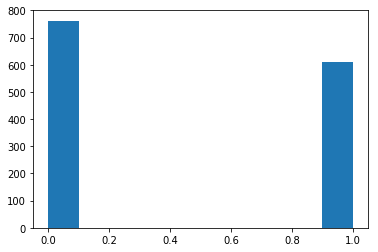

In [7]:
hist=plt.hist(df_input['Class'].values.reshape(-1,1))

###  Sequential model:
I played around with different parameters and I found that the relu activation function in the hidden layers works better than the sigmoid. I also use softmax in the output. There is not much difference between softmax and sigmoid as targets are hot encoded.

In [8]:
#the number of neurons n in the hidden layers (which are Dense layers) is 10,
# with sigmoid activation functions. The dropout out ratio is 0.25.
# The final output layer is also a Dense layer with n = 1 and softmax activation.
model = Sequential()
model.add(Dense(10, activation='relu', input_dim= dim2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

#Compilation
model.compile(loss='binary_crossentropy',
                optimizer='Adadelta',
                metrics=['accuracy', f1])

# Train the model, iterating on the data in batches of 32 samples
model.fit(x_train, y_train, epochs=40, batch_size=32, validation_split=0.2)



results = model.predict_classes(x_test, batch_size=32)



plt.show()



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 932 samples, validate on 234 samples
Epoch 1/40
932/932 [==============================] - 2s 2ms/step - loss: 0.6986 - acc: 0.5043 - f1: 0.5043 - val_loss: 0.6836 - val_acc: 0.5983 - val_f1: 0.5983
Epoch 2/40
932/932 [==============================] - 0s 72us/step - loss: 0.6830 - acc: 0.5397 - f1: 0.5397 - val_loss: 0.6750 - val_acc: 0.5299 - val_f1: 0.5299
Epoch 3/40
932/932 [==============================] - 0s 70us/step - loss: 0.6739 - acc: 0.5408 - f1: 0.5408 - val_loss: 0.6673 - val_acc: 0.5299 - val_f1: 0.5299
Epoch 4/40
932/932 [==============================] - 0s 78us/step - loss: 0.6614 - acc: 0.5526 - f1: 0.5526 - val_loss: 0.6571 - val_acc: 0.5299 - val_f1: 0.5299
Epoch 5/40
932/932 [==============================] - 0s 82us/step -

## Confusion matrix for sequential model

In [9]:
confusion_matrix(y_test, results)

array([[113,   4],
       [  8,  81]], dtype=int64)

### Functional API

Two models (one with and the other without residual connections)

In [13]:
#Model
inputs = Input(shape=(dim2,))

l1 = Dense(10, activation='relu')(inputs)
l2 = Dense(10, activation='relu')(l1)
l3 = Dropout(0.25)(l2)
x=concatenate([l2, l3])
predictions1 = Dense(2, activation='softmax')(x) #residual connections
predictions2 = Dense(2, activation='softmax')(l3) #non-residually connected network


model1 = Model(inputs=inputs, outputs=predictions1) #residual connections

model2 = Model(inputs=inputs, outputs=predictions2) #non-residually connected network
#Compilation
model1.compile(loss='binary_crossentropy',
                optimizer='Nadam',
                metrics=['accuracy', f1])

model2.compile(loss='binary_crossentropy',
                optimizer='Nadam',
                metrics=['accuracy', f1])

# Train the model, iterating on the data in batches of 32 samples
model1.fit(x_train, y_train, epochs=40, batch_size=32, validation_split=0.2) #residual connections
results1 = model1.predict(x_test, batch_size=32)
y_pred1=results1.argmax(axis=-1)

model2.fit(x_train, y_train, epochs=40, batch_size=32, validation_split=0.2)
results2 = model2.predict(x_test, batch_size=32)#non-residually connected network
y_pred2=results2.argmax(axis=-1)




Train on 932 samples, validate on 234 samples
Epoch 1/40
932/932 [==============================] - 1s 1ms/step - loss: 0.6727 - acc: 0.5622 - f1: 0.5622 - val_loss: 0.6840 - val_acc: 0.5299 - val_f1: 0.5299
Epoch 2/40
932/932 [==============================] - 0s 117us/step - loss: 0.6650 - acc: 0.5590 - f1: 0.5590 - val_loss: 0.6651 - val_acc: 0.5299 - val_f1: 0.5299
Epoch 3/40
932/932 [==============================] - 0s 112us/step - loss: 0.6486 - acc: 0.5590 - f1: 0.5590 - val_loss: 0.6536 - val_acc: 0.5299 - val_f1: 0.5299
Epoch 4/40
932/932 [==============================] - 0s 89us/step - loss: 0.6323 - acc: 0.5601 - f1: 0.5601 - val_loss: 0.6250 - val_acc: 0.5556 - val_f1: 0.5556
Epoch 5/40
932/932 [==============================] - 0s 96us/step - loss: 0.6038 - acc: 0.6019 - f1: 0.6019 - val_loss: 0.6002 - val_acc: 0.5983 - val_f1: 0.5983
Epoch 6/40
932/932 [==============================] - 0s 111us/step - loss: 0.5707 - acc: 0.6781 - f1: 0.6781 - val_loss: 0.5620 - val_acc

932/932 [==============================] - 0s 116us/step - loss: 0.3289 - acc: 0.8788 - f1: 0.8788 - val_loss: 0.2673 - val_acc: 0.9530 - val_f1: 0.9530
Epoch 11/40
932/932 [==============================] - 0s 72us/step - loss: 0.3281 - acc: 0.8863 - f1: 0.8863 - val_loss: 0.2408 - val_acc: 0.9573 - val_f1: 0.9573
Epoch 12/40
932/932 [==============================] - 0s 91us/step - loss: 0.2893 - acc: 0.9024 - f1: 0.9024 - val_loss: 0.2290 - val_acc: 0.9573 - val_f1: 0.9573
Epoch 13/40
932/932 [==============================] - 0s 82us/step - loss: 0.2768 - acc: 0.9185 - f1: 0.9185 - val_loss: 0.2000 - val_acc: 0.9530 - val_f1: 0.9530
Epoch 14/40
932/932 [==============================] - 0s 74us/step - loss: 0.2709 - acc: 0.9142 - f1: 0.9142 - val_loss: 0.1951 - val_acc: 0.9744 - val_f1: 0.9744
Epoch 15/40
932/932 [==============================] - 0s 75us/step - loss: 0.2541 - acc: 0.9131 - f1: 0.9131 - val_loss: 0.1939 - val_acc: 0.9573 - val_f1: 0.9573
Epoch 16/40
932/932 [======

### Confusion matrix for functional model with no residual connections

In [14]:
confusion_matrix(y_test, y_pred1)



array([[117,   0],
       [  2,  87]], dtype=int64)

### Confusion matrix for functional model with one residual connections

In [15]:
confusion_matrix(y_test, y_pred2)

array([[115,   2],
       [  0,  89]], dtype=int64)